In [1]:
import os
import torch
import matplotlib.pyplot as plt

In [2]:
from NRI.models import DynamicNeuralRelationalInference
from NRI.experiments.config import ExperimentConfig

experiment_config = ExperimentConfig(
    obs_len=12,
    pred_len=12,
    encoder_loss_weight=1.0,
    decoder_loss_weight=1.0,
    signal_loss_weight=1.0,
    n_epoch=20,
    batch_size=32,
    checkpoint_prefix='dnri',
    checkpoint_interval=10,
    use_cuda=True,
)

model = DynamicNeuralRelationalInference(
    hid_dim=64,
    n_edges=4,
    dgvae=False
)

In [3]:
from SinD.config import get_dataset_path
from SinD.dataset.io import get_dataset_records
from NRI.dataset import SignalizedIntersectionDatasetForNRI, SignalizedIntersectionDatasetConfig
from NRI.dataset.utils import split_dataset

dataset_path = get_dataset_path()
dataset_files = get_dataset_records(dataset_path)
train_files, _, test_files = split_dataset(dataset_files, 0.7, 0.2)

dataset_config = SignalizedIntersectionDatasetConfig(
    obs_len=experiment_config.obs_len,
    pred_len=experiment_config.pred_len,
    stride=15,
    encode_traffic_signals=True,
    padding_value=0.0,
    include_incomplete_trajectories=False
)

test_set = SignalizedIntersectionDatasetForNRI(dataset_config)
test_set.load_records(dataset_path, test_files, verbose=True)

load_records: 100%|██████████| 3/3 [00:38<00:00, 12.76s/it]


load model

In [4]:
model.load_state_dict(torch.load('../checkpoints/dnri_12_baseline_best.pt')['params'])

<All keys matched successfully>

In [5]:
from NRI.experiments.test import generate_result

test_stats = generate_result(model, test_set, experiment_config, feed_true_signals=False)

[test] generating result:   0%|          | 0/67 [00:00<?, ?it/s]c:\Users\chinp\source\AnythingVisionaries\venv\Lib\site-packages\torch\nested\__init__.py:166: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ..\aten\src\ATen\NestedTensorImpl.cpp:180.)
  return _nested.nested_tensor(
[test] generating result: 100%|██████████| 67/67 [00:08<00:00,  7.78it/s]

=== Overall Result ===
Signal Prediction Accuracy: 0.7746423482894897
Overall Final Displacement Error: 1.9626095294952393
Overall Average Displacement Error: 0.7696870565414429
=== Displacement Error of Class `pedestrian` ===
FDE: 3.5562590224433763
ADE: 1.9006439310785097
=== Displacement Error of Class `car` ===
FDE: 2.2104906017287638
ADE: 0.5796984104869637
=== Displacement Error of Class `truck` ===
FDE: 20.92800327654808
ADE: 5.91180552782551
=== Displacement Error of Class `bus` ===
FDE: 0.05091798442114234
ADE: 0.02343645601461781
=== Displacement Error of Class `motorcycle` ===
FDE: 2.2600983573505893
ADE: 0.8208529115525943
=== Displacement Error of Class `tricycle` ===
FDE: 1.162292818717376
ADE: 0.49815768723508325
=== Displacement Error of Class `bicycle` ===
FDE: 3.543439434555878
ADE: 1.5219776946920185


<Axes: >

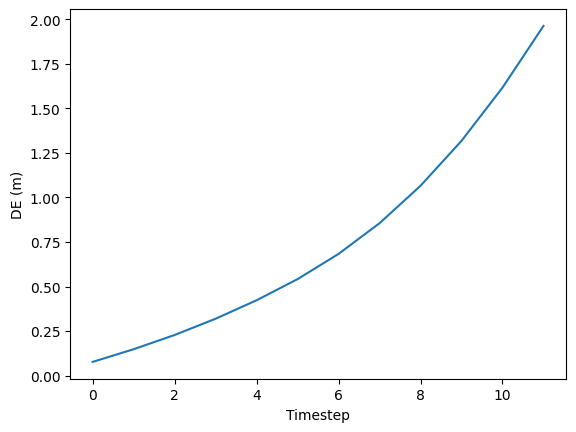

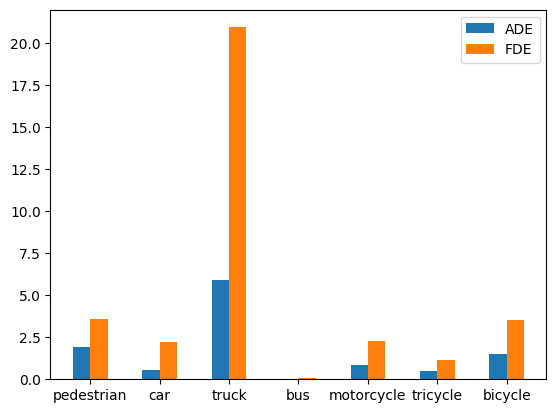

In [6]:
from NRI.experiments.visualize import plot_de_by_step, plot_de_by_class

plot_de_by_step(test_stats.de_by_step)
plot_de_by_class(test_stats.ade_by_class, test_stats.fde_by_class)

Selected: 1941


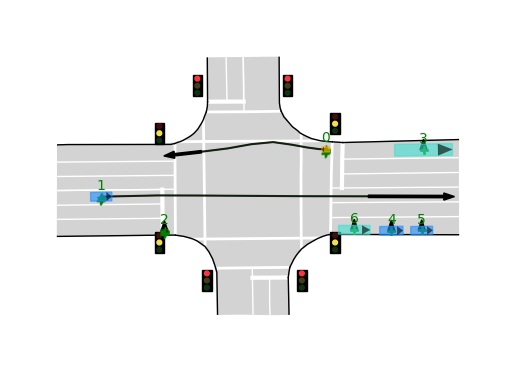

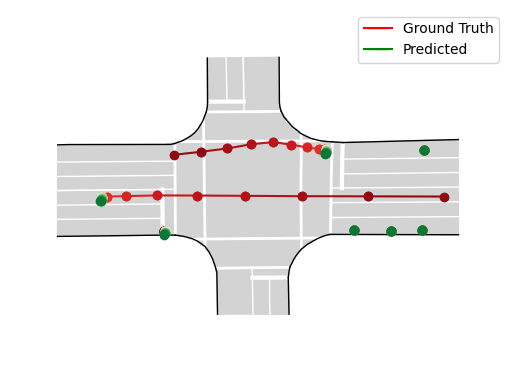

In [51]:
import importlib
import NRI.experiments.visualize
import SinD.vis.map
importlib.reload(NRI.experiments.visualize)
importlib.reload(SinD.vis.map)

from SinD.vis.map import IntersectionMap
from NRI.experiments.visualize import plot_predicted_trajectories, plot_kigan

import random

model.cpu()

index = random.randrange(0, len(test_set))

print(f'Selected: {index}')

(
    trajectory,
    trajectory_mask,
    _,
    agent_records,
    agent_flags,
    signals,
    graph_info
) = test_set[index]

with torch.no_grad():
    predicted_trajectory, _, _, predicted_signals = model.predict_future(
        trajectory[:, :experiment_config.obs_len],
        trajectory_mask[:, :experiment_config.obs_len],
        agent_records,
        agent_flags[..., 0].int(),
        signals[:experiment_config.obs_len, 0].int(),
        n_steps=experiment_config.pred_len,
        graph_info=graph_info,
        put_nan=False,
        output_mode='point'
    )

map = IntersectionMap()

ax = plot_predicted_trajectories(
    trajectory,
    predicted_trajectory,
    trajectory_mask,
    agent_flags,
    agent_records,
    signals,
    map,
    dataset_config
)

kigan_ax = plot_kigan(
    trajectory,
    predicted_trajectory,
    map,
    dataset_config
)